# Day 1: K-Means Clustering for Trading

## 🎯 Learning Objectives
- Understand K-Means algorithm
- Apply to market regime detection
- Build regime-based trading strategies

---

## 📚 Theory: K-Means

### Algorithm
1. Initialize k centroids randomly
2. Assign points to nearest centroid
3. Update centroids as cluster means
4. Repeat until convergence

### Objective
$$\min_C \sum_{i=1}^{k}\sum_{x\in C_i} ||x - \mu_i||^2$$

### Finance Applications
- Market regime detection (bull/bear/sideways)
- Asset clustering for diversification
- Customer segmentation

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 2513 days


In [2]:
# Create regime features
df = pd.DataFrame(index=returns.index)
df['return'] = returns
df['return_20d'] = returns.rolling(20).mean()
df['volatility_20d'] = returns.rolling(20).std() * np.sqrt(TRADING_DAYS)
df['momentum_20d'] = prices.pct_change(20)

df = df.dropna()
feature_cols = ['return_20d', 'volatility_20d', 'momentum_20d']

print(f"📊 Samples: {len(df)}")

📊 Samples: 2493


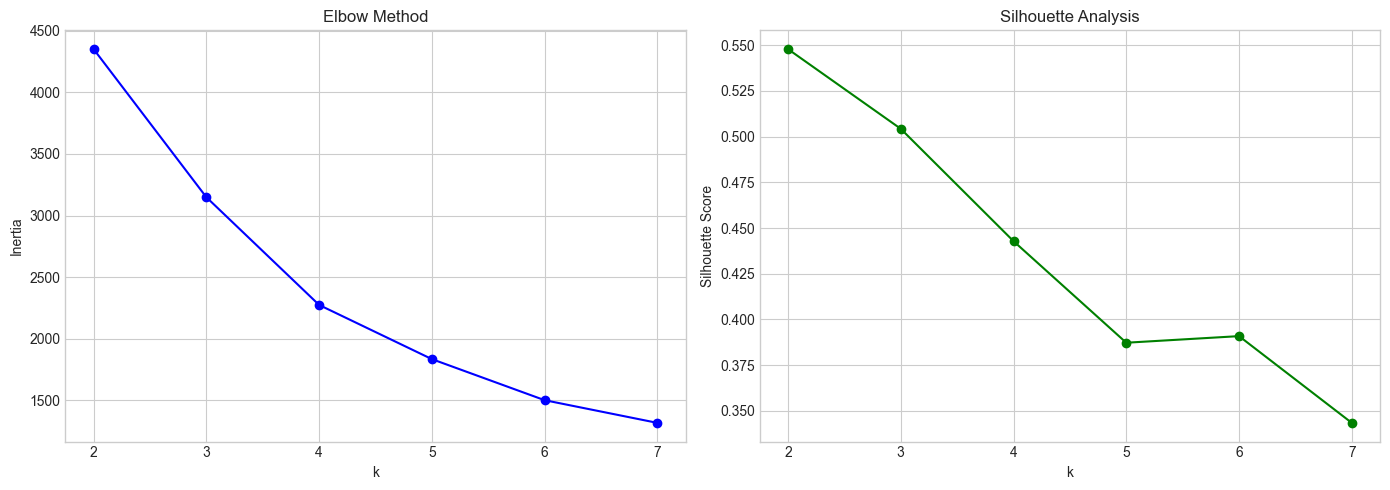


📊 Best k by silhouette: 2


In [3]:
# Find optimal k using elbow method and silhouette
X = df[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_range = range(2, 8)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

axes[1].plot(k_range, silhouettes, 'go-')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()

best_k = k_range[np.argmax(silhouettes)]
print(f"\n📊 Best k by silhouette: {best_k}")

In [4]:
# Fit K-Means with optimal k (or 3 for interpretability)
k = 3  # Bull, Bear, Sideways
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['regime'] = kmeans.fit_predict(X_scaled)

# Analyze regimes
print("\n" + "="*60)
print("REGIME ANALYSIS")
print("="*60)

regime_stats = df.groupby('regime').agg({
    'return': 'mean',
    'return_20d': 'mean',
    'volatility_20d': 'mean',
    'momentum_20d': 'mean'
}).round(4)

# Label regimes based on characteristics
regime_labels = {}
for r in range(k):
    avg_ret = regime_stats.loc[r, 'return_20d']
    avg_vol = regime_stats.loc[r, 'volatility_20d']
    if avg_ret > 0 and avg_vol < regime_stats['volatility_20d'].median():
        regime_labels[r] = 'Bull'
    elif avg_ret < 0:
        regime_labels[r] = 'Bear'
    else:
        regime_labels[r] = 'Sideways'

df['regime_label'] = df['regime'].map(regime_labels)
print(regime_stats)
print(f"\nRegime Labels: {regime_labels}")


REGIME ANALYSIS
        return  return_20d  volatility_20d  momentum_20d
regime                                                  
0      -0.0018     -0.0018          0.2060       -0.0370
1      -0.0018     -0.0092          0.8049       -0.1862
2       0.0015      0.0016          0.1218        0.0311

Regime Labels: {0: 'Bear', 1: 'Bear', 2: 'Bull'}


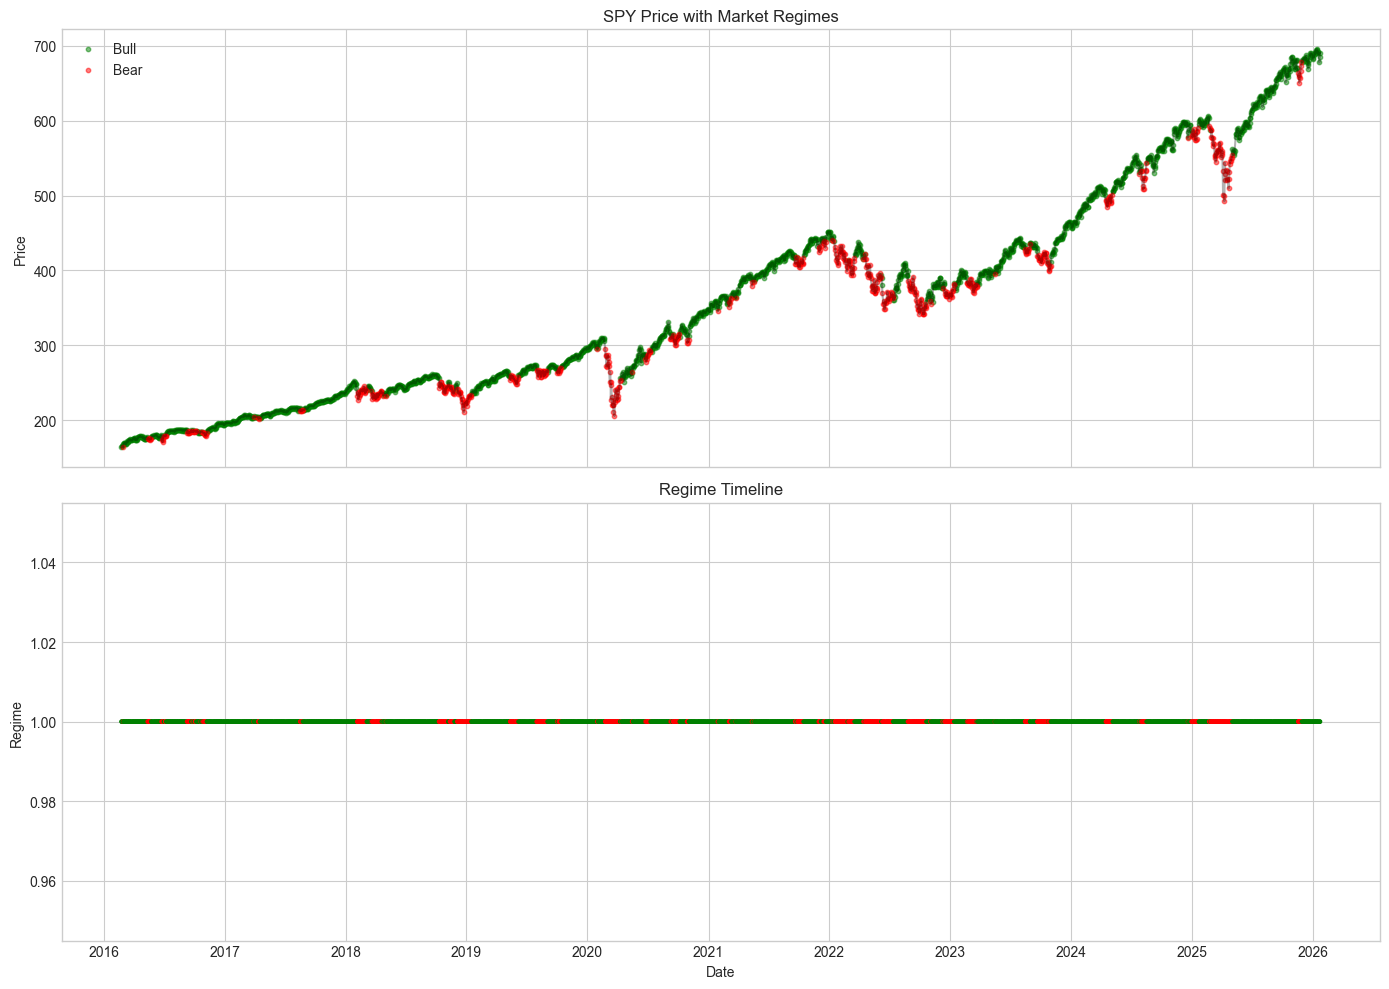

In [5]:
# Visualize regimes
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Price with regime coloring
price_aligned = prices.loc[df.index]
colors = {'Bull': 'green', 'Bear': 'red', 'Sideways': 'gray'}

axes[0].plot(price_aligned.index, price_aligned.values, 'k-', alpha=0.3)
for regime in df['regime_label'].unique():
    mask = df['regime_label'] == regime
    axes[0].scatter(df.index[mask], price_aligned[mask], 
                   c=colors[regime], label=regime, alpha=0.5, s=10)
axes[0].set_title(f'{ticker} Price with Market Regimes')
axes[0].set_ylabel('Price')
axes[0].legend()

# Regime timeline
regime_colors = [colors[df['regime_label'].iloc[i]] for i in range(len(df))]
axes[1].scatter(df.index, [1]*len(df), c=regime_colors, s=5)
axes[1].set_title('Regime Timeline')
axes[1].set_ylabel('Regime')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

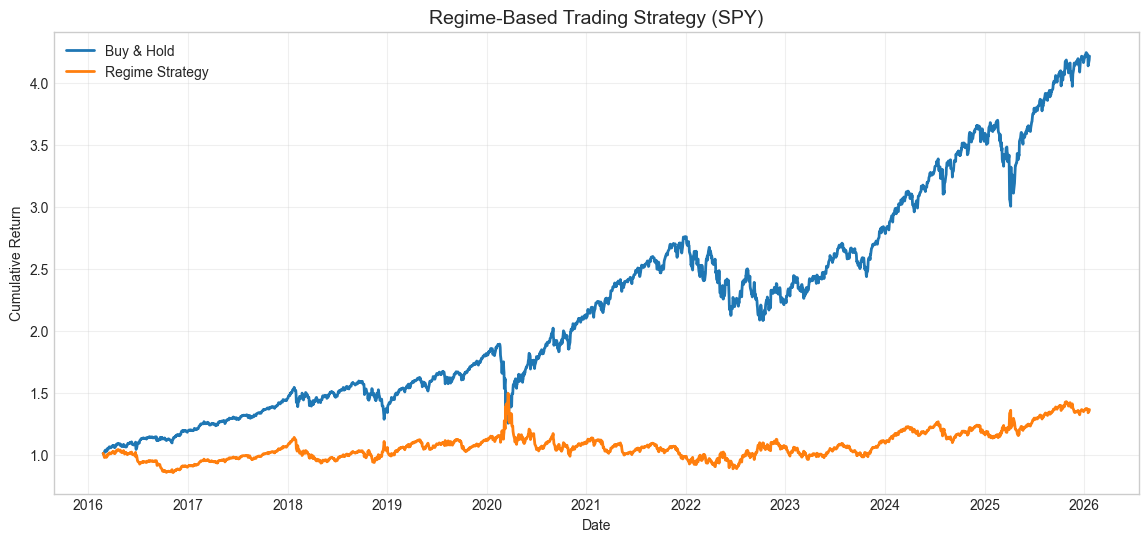

In [6]:
# Regime-based trading strategy
df['next_return'] = df['return'].shift(-1)
df = df.dropna()

# Strategy: Long in Bull, Short in Bear, Out in Sideways
df['signal'] = df['regime_label'].map({'Bull': 1, 'Bear': -1, 'Sideways': 0})
df['strategy_return'] = df['signal'] * df['next_return']

# Cumulative returns
df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buy_hold_cum'] = (1 + df['next_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(df.index, df['strategy_cum'], label='Regime Strategy', linewidth=2)
plt.title(f'Regime-Based Trading Strategy ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd = calc_metrics(df['next_return'], df['buy_hold_cum'])
st_total, st_sharpe, st_mdd = calc_metrics(df['strategy_return'], df['strategy_cum'])

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)
print(f"{'Buy & Hold':<20} {bh_total:>12.2%} {bh_sharpe:>10.2f} {bh_mdd:>10.2%}")
print(f"{'Regime Strategy':<20} {st_total:>12.2%} {st_sharpe:>10.2f} {st_mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                321.74%       0.62    -33.72%
Regime Strategy            36.53%      -0.01    -40.68%


In [8]:
# Next day prediction
latest = df[feature_cols].iloc[[-1]]
latest_scaled = scaler.transform(latest)
current_regime = kmeans.predict(latest_scaled)[0]
current_label = regime_labels[current_regime]

print("\n" + "="*60)
print(f"📊 CURRENT MARKET REGIME FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nCurrent Regime: {current_label}")
print(f"\n{'📈 LONG' if current_label == 'Bull' else '📉 SHORT' if current_label == 'Bear' else '⏸️ STAY OUT'} recommended")
print(f"\nRegime Characteristics:")
print(f"  20d Return: {df['return_20d'].iloc[-1]:.2%}")
print(f"  20d Volatility: {df['volatility_20d'].iloc[-1]:.1%}")
print(f"  20d Momentum: {df['momentum_20d'].iloc[-1]:.2%}")


📊 CURRENT MARKET REGIME FOR SPY

Date: 2026-01-21

Current Regime: Bull

📈 LONG recommended

Regime Characteristics:
  20d Return: 0.04%
  20d Volatility: 10.7%
  20d Momentum: 0.71%


---

## 🏢 Real-World Applications

| Company | K-Means Use Case |
|---------|-----------------|
| Bridgewater | Economic regime detection |
| AQR | Factor regime classification |
| Two Sigma | Market state identification |

### Key Interview Points
1. **Why K-Means?** - Simple, fast, interpretable
2. **Choosing k?** - Elbow method, silhouette, domain knowledge
3. **Limitations?** - Assumes spherical clusters, sensitive to initialization

---
## 📅 Tomorrow: Hierarchical Clustering